Adding a google drive

In [1]:
!nvidia-smi

Thu Jul 20 06:22:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


This module will plot live charts during fit (defined in callback parameter)

In [3]:
!pip3 install livelossplot

Imports

In [4]:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as matimage
import cv2

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D, ReLU, concatenate
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras import regularizers, optimizers

from livelossplot import PlotLossesKeras

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import OneHotEncoder

import os
import time
import datetime
import glob

import plotly.express as px

In [5]:
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201, preprocess_input
# from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
# from keras.applications.xception import Xception, preprocess_input

Defining file paths and counting files

In [6]:
SOURCE_PATH = '/content/drive/MyDrive/PetImages'

# os.listdir returns a list containing all files under the given path
start = time.time()
CAT_PATH = os.listdir(os.path.join(SOURCE_PATH, 'Cat'))
DOG_PATH = os.listdir(os.path.join(SOURCE_PATH, 'Dog'))

CAT_PATH = list(map(lambda x : os.path.join(SOURCE_PATH+"/Cat", x), CAT_PATH))
DOG_PATH = list(map(lambda x : os.path.join(SOURCE_PATH+"/Dog", x), DOG_PATH))
end = time.time()

print(f"{len(CAT_PATH)} cats img")
print(f"{len(DOG_PATH)} dogs img")
print(f'\n{end-start} sec.')

12500 cats img
12500 dogs img

101.91278767585754 sec.


In [7]:
df = pd.DataFrame({"path":CAT_PATH+DOG_PATH,"label":[0]*len(CAT_PATH)+[1]*len(DOG_PATH)})
df.head()

path  label
0  /content/drive/MyDrive/PetImages/Cat/8907.jpg      0
1  /content/drive/MyDrive/PetImages/Cat/9120.jpg      0
2  /content/drive/MyDrive/PetImages/Cat/8898.jpg      0
3  /content/drive/MyDrive/PetImages/Cat/9220.jpg      0
4  /content/drive/MyDrive/PetImages/Cat/9102.jpg      0

In [8]:
# If you have data.csv - Skip here (serach for '# If you have data.csv - From here on...')

In [ ]:
df.shape

(25000, 2)

Check each image file for corrupted or missing immage files, then remove them from the dataframe

In [ ]:
def data_check():
    """
        check each image file for corrupted or missing
    """
    error = []
    start = time.time()
    for i in range(len(df)):
        try:                    # checks for corrupeted or missing image files
            if len(cv2.imread(df.iloc[i,0])) == 3:
                _ = 1
        except:
            print(i)
            error.append(df.iloc[i,0])
    end = time.time()
    print(f'\n{end-start} sec.')
    return error

In [ ]:
remove = data_check()

In [ ]:
df = df[~df["path"].isin(remove)]

In [ ]:
df.to_csv('/content/drive/MyDrive/PetImages/data.csv', index=False)

In [ ]:
# If you have data.csv - From here on...

In [8]:
df = pd.read_csv('/content/drive/MyDrive/PetImages/data.csv')

Data check (quantity)

In [9]:
cd_names = ['Cat', 'Dog']
n_cats = len(df.loc[df['label']==0])
n_dogs = len(df.loc[df['label']==1])
n_images = [n_cats, n_dogs]
px.pie(names=cd_names, values=n_images).update_layout(width=300, height=300)

In [10]:
df

path  label
0       /content/drive/MyDrive/PetImages/Cat/8907.jpg      0
1       /content/drive/MyDrive/PetImages/Cat/9120.jpg      0
2       /content/drive/MyDrive/PetImages/Cat/8898.jpg      0
3       /content/drive/MyDrive/PetImages/Cat/9220.jpg      0
4       /content/drive/MyDrive/PetImages/Cat/9102.jpg      0
...                                               ...    ...
24941  /content/drive/MyDrive/PetImages/Dog/10081.jpg      1
24942  /content/drive/MyDrive/PetImages/Dog/10045.jpg      1
24943  /content/drive/MyDrive/PetImages/Dog/10100.jpg      1
24944  /content/drive/MyDrive/PetImages/Dog/10619.jpg      1
24945  /content/drive/MyDrive/PetImages/Dog/10752.jpg      1

[24946 rows x 2 columns]

Index where the next class is

In [11]:
df['path'][12475:12477]

12475    /content/drive/MyDrive/PetImages/Cat/10737.jpg
12476     /content/drive/MyDrive/PetImages/Dog/9142.jpg
Name: path, dtype: object

In [12]:
df['path'][::4]

0         /content/drive/MyDrive/PetImages/Cat/8907.jpg
4         /content/drive/MyDrive/PetImages/Cat/9102.jpg
8         /content/drive/MyDrive/PetImages/Cat/9151.jpg
12        /content/drive/MyDrive/PetImages/Cat/8862.jpg
16        /content/drive/MyDrive/PetImages/Cat/8974.jpg
                              ...                      
24928    /content/drive/MyDrive/PetImages/Dog/10203.jpg
24932    /content/drive/MyDrive/PetImages/Dog/10014.jpg
24936    /content/drive/MyDrive/PetImages/Dog/10432.jpg
24940     /content/drive/MyDrive/PetImages/Dog/1008.jpg
24944    /content/drive/MyDrive/PetImages/Dog/10619.jpg
Name: path, Length: 6237, dtype: object

The first split - into training and test set.
Training set will be split into training and validation set.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['path'][::2], df['label'][::2], test_size=0.1, random_state=42)

df_train = pd.DataFrame({"path":X_train,"label":y_train})
df_test = pd.DataFrame({"path":X_test,"label":y_test})

df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

Using ImageDataGenerator and rescaling images.
Training set will be split into training and validation set.

In [14]:
train_datagen = ImageDataGenerator(rescale=1 / 255.0, validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [15]:
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224

Using flow_from_dataframe for traning, validation and test.

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="path",
    y_col="label",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="rgb",
    #classes=["Cat", "Dog"],
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="path",
    y_col="label",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="rgb",
    #classes=["Cat", "Dog"],
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=None,
    x_col="path",
    y_col=None,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="rgb",
    class_mode=None,
    batch_size=1,
    shuffle=False,
    seed=42
)

Found 8980 validated image filenames belonging to 2 classes.
Found 2245 validated image filenames belonging to 2 classes.
Found 1248 validated image filenames.


In [17]:
train_generator.class_indices, valid_generator.class_indices

({'0': 0, '1': 1}, {'0': 0, '1': 1})

In [18]:
train_generator.filepaths[-4:]

['/content/drive/MyDrive/PetImages/Cat/11943.jpg',
 '/content/drive/MyDrive/PetImages/Cat/12052.jpg',
 '/content/drive/MyDrive/PetImages/Cat/9275.jpg',
 '/content/drive/MyDrive/PetImages/Dog/6981.jpg']

In [19]:
train_generator.classes[-4:]

[0, 0, 0, 1]

Build Model - DenseNet 121

In [28]:
def densenet121(input_shape, n_classes, filters = 32):

    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):

        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x

    def dense_block(x, repetition):

        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x

    def transition_layer(x):

        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x

    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)

    for repetition in [6,12,24,16]:

        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(2, activation = 'sigmoid')(x)

    model = Model(input, output)

    model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy',
                           #tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')
                           ])
    return model

In [29]:
input_shape = 224, 224, 3
model = densenet121(input_shape, 2)

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_121 (Conv2D)            (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 64)  0           ['conv2d_121[0][0]']             
                                                                                            

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.700524 to fit



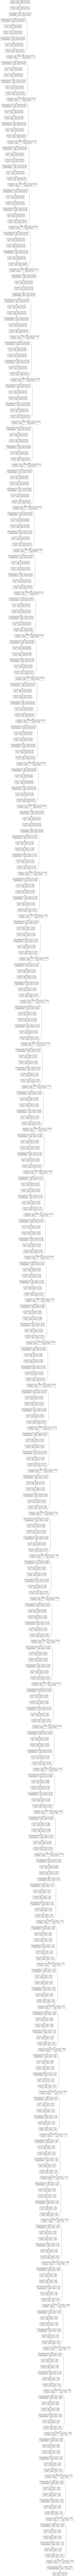

In [31]:
keras.utils.plot_model(model, show_shapes=True)

Define Callback

In [32]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=7)

Train Model || Plot Model Performance || Save Best Model

In [33]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

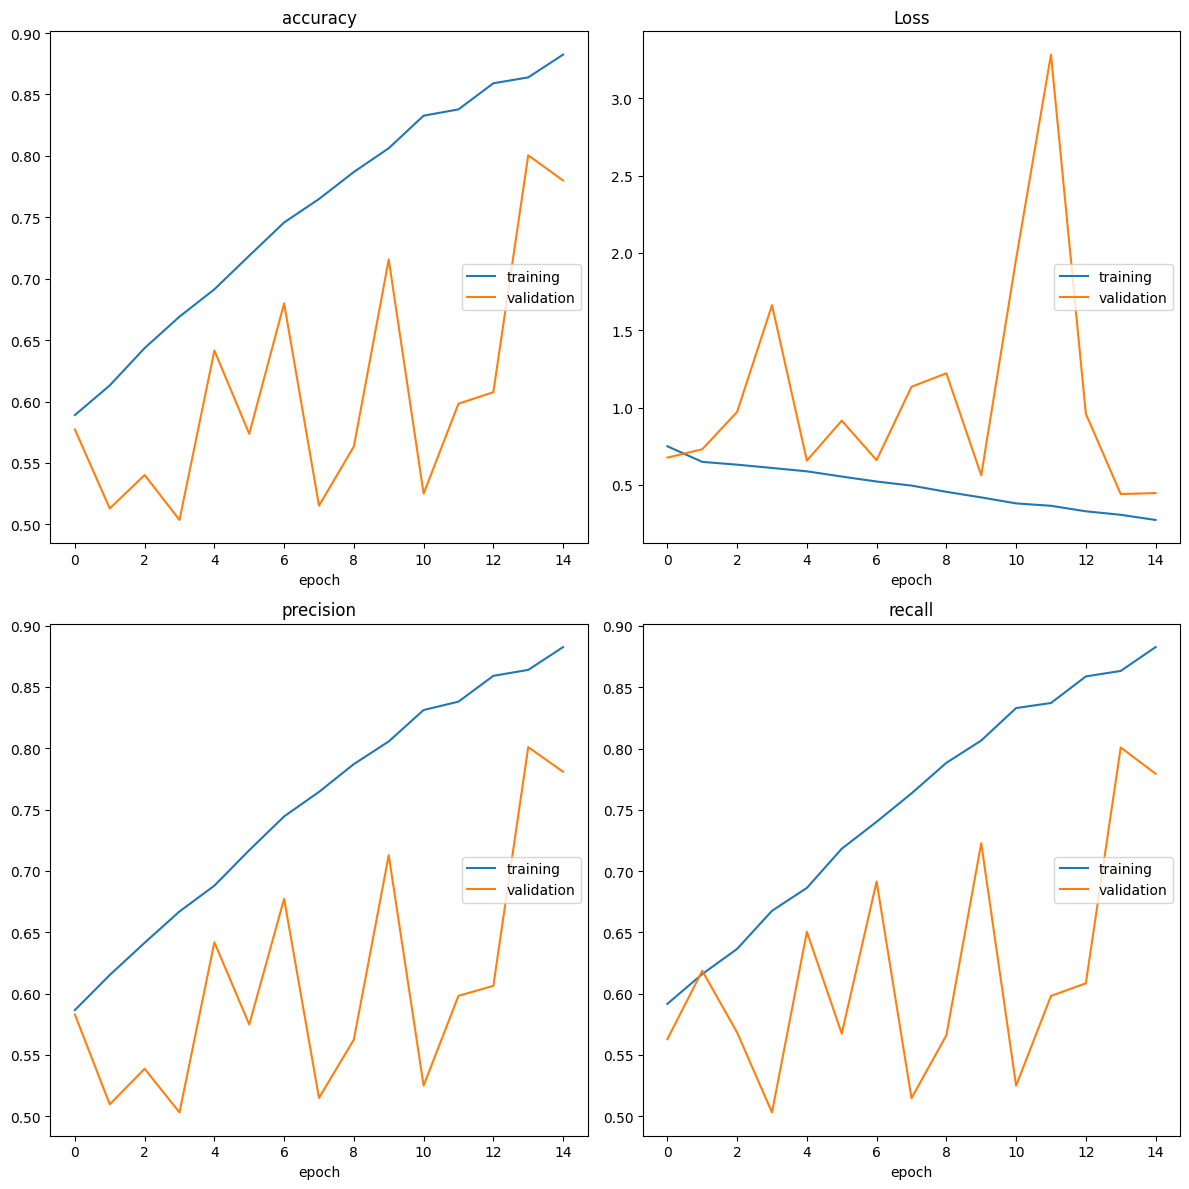

accuracy
	training         	 (min:    0.589, max:    0.882, cur:    0.882)
	validation       	 (min:    0.504, max:    0.800, cur:    0.780)
Loss
	training         	 (min:    0.273, max:    0.750, cur:    0.273)
	validation       	 (min:    0.441, max:    3.283, cur:    0.447)
precision
	training         	 (min:    0.587, max:    0.882, cur:    0.882)
	validation       	 (min:    0.503, max:    0.801, cur:    0.781)
recall
	training         	 (min:    0.592, max:    0.883, cur:    0.883)
	validation       	 (min:    0.503, max:    0.801, cur:    0.779)
280/280 [==============================] - 75s 267ms/step - loss: 0.2729 - accuracy: 0.8824 - precision: 0.8825 - recall: 0.8828 - val_loss: 0.4468 - val_accuracy: 0.7799 - val_precision: 0.7809 - val_recall: 0.7795


In [34]:
history = model.fit_generator(train_generator,
                              validation_data = valid_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              validation_steps = STEP_SIZE_VALID,
                              use_multiprocessing = False,
                              epochs=15,
                              callbacks=[#es_callback,
                                         PlotLossesKeras()]
                              )

model.save("/content/drive/MyDrive/PetImages/densenet121.h5")

Load Best Model

In [22]:
model = tf.keras.models.load_model("/content/drive/MyDrive/PetImages/densenet121.h5")

Evaluate model

In [36]:
print("Evaluate on test data")
eval = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
print("Validation accuracy:", eval[1])
print("Validation loss:", eval[0])
print("Validation precision:", eval[2])
print("Validation recall:", eval[3])
val_f1 = 2*(eval[2]*eval[3])/(eval[2]+eval[3])
print("Validation f1-score:", val_f1)

Evaluate on test data


<ipython-input-36-fe1039be6315>:2: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Validation accuracy: 0.7799107432365417
Validation loss: 0.4462912380695343
Validation precision: 0.7808586955070496
Validation recall: 0.7794643044471741
Validation f1-score: 0.7801608769245683


In [32]:
np.save('/content/drive/MyDrive/PetImages/eval.npy', eval)

In [ ]:
eval = np.load('/content/drive/MyDrive/PetImages/eval.npy')

Test model

In [37]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

test_generator.reset()
pred = model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

<ipython-input-37-c3ae3130213c>:4: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



1248/1248 [==============================] - 308s 245ms/step


In [34]:
np.save('/content/drive/MyDrive/PetImages/pred.npy', pred)

In [ ]:
pred = np.load('/content/drive/MyDrive/PetImages/pred.npy')

Printing some results (dataframe)

In [38]:
predicted_class_indices=np.argmax(pred, axis=1)

In [39]:
filenames = test_generator.filenames
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

results = pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

results['Predictions'] = results['Predictions'].astype(int)

In [40]:
results[:10]

Filename  Predictions
0   /content/drive/MyDrive/PetImages/Dog/2646.jpg            1
1   /content/drive/MyDrive/PetImages/Cat/9177.jpg            0
2   /content/drive/MyDrive/PetImages/Cat/7147.jpg            1
3   /content/drive/MyDrive/PetImages/Cat/6086.jpg            0
4  /content/drive/MyDrive/PetImages/Cat/11199.jpg            1
5   /content/drive/MyDrive/PetImages/Dog/8471.jpg            1
6   /content/drive/MyDrive/PetImages/Dog/8420.jpg            1
7   /content/drive/MyDrive/PetImages/Dog/8985.jpg            1
8   /content/drive/MyDrive/PetImages/Cat/4758.jpg            0
9    /content/drive/MyDrive/PetImages/Dog/665.jpg            1

Printing some results (images)

In [41]:
class_names = ['Cat', 'Dog']

def show_25_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")

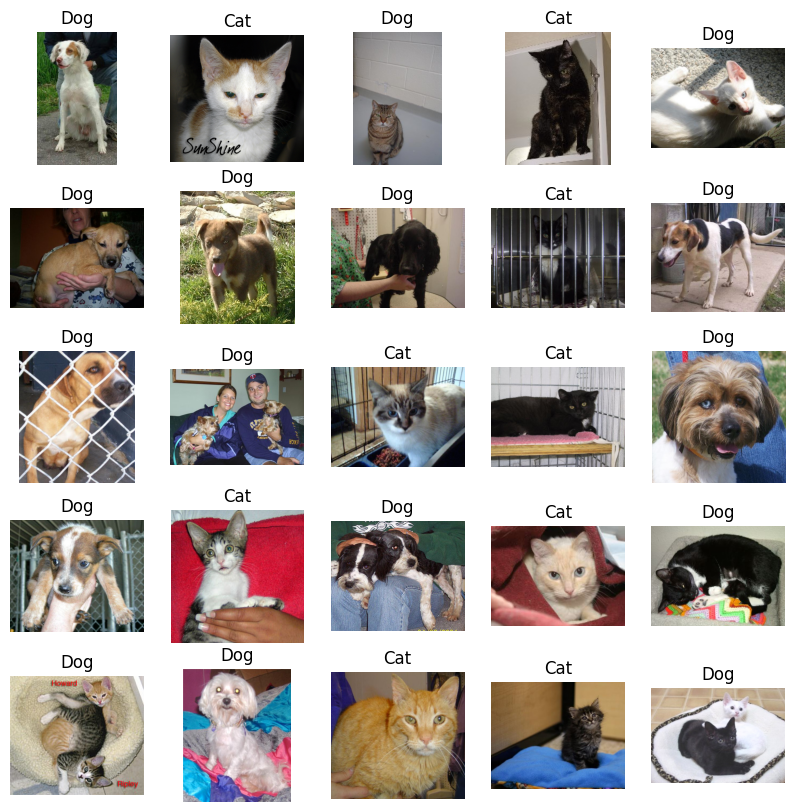

In [42]:
show_25_images(results['Filename'], results['Predictions'])

DenseNet121, DenseNet169, DenseNet201 - but imported from keras.applications

In [43]:
image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 15
batch_size = 32

DenseNet121

In [44]:
model_dn_121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [45]:
for layer in model_dn_121.layers:
    layer.trainable = False

x = Flatten()(model_dn_121.output)
pred_121 = Dense(2, activation = 'sigmoid')(x)
final_model_dn_121 = Model(inputs = model_dn_121.input, outputs = pred_121)

final_model_dn_121.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
final_model_dn_121.compile(loss="binary_crossentropy",
                           optimizer=Adam(learning_rate=0.00001),
                           metrics=['accuracy',
                                    #tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                                    tf.keras.metrics.Precision(name='precision'),
                                    tf.keras.metrics.Recall(name='recall')
                                   ])

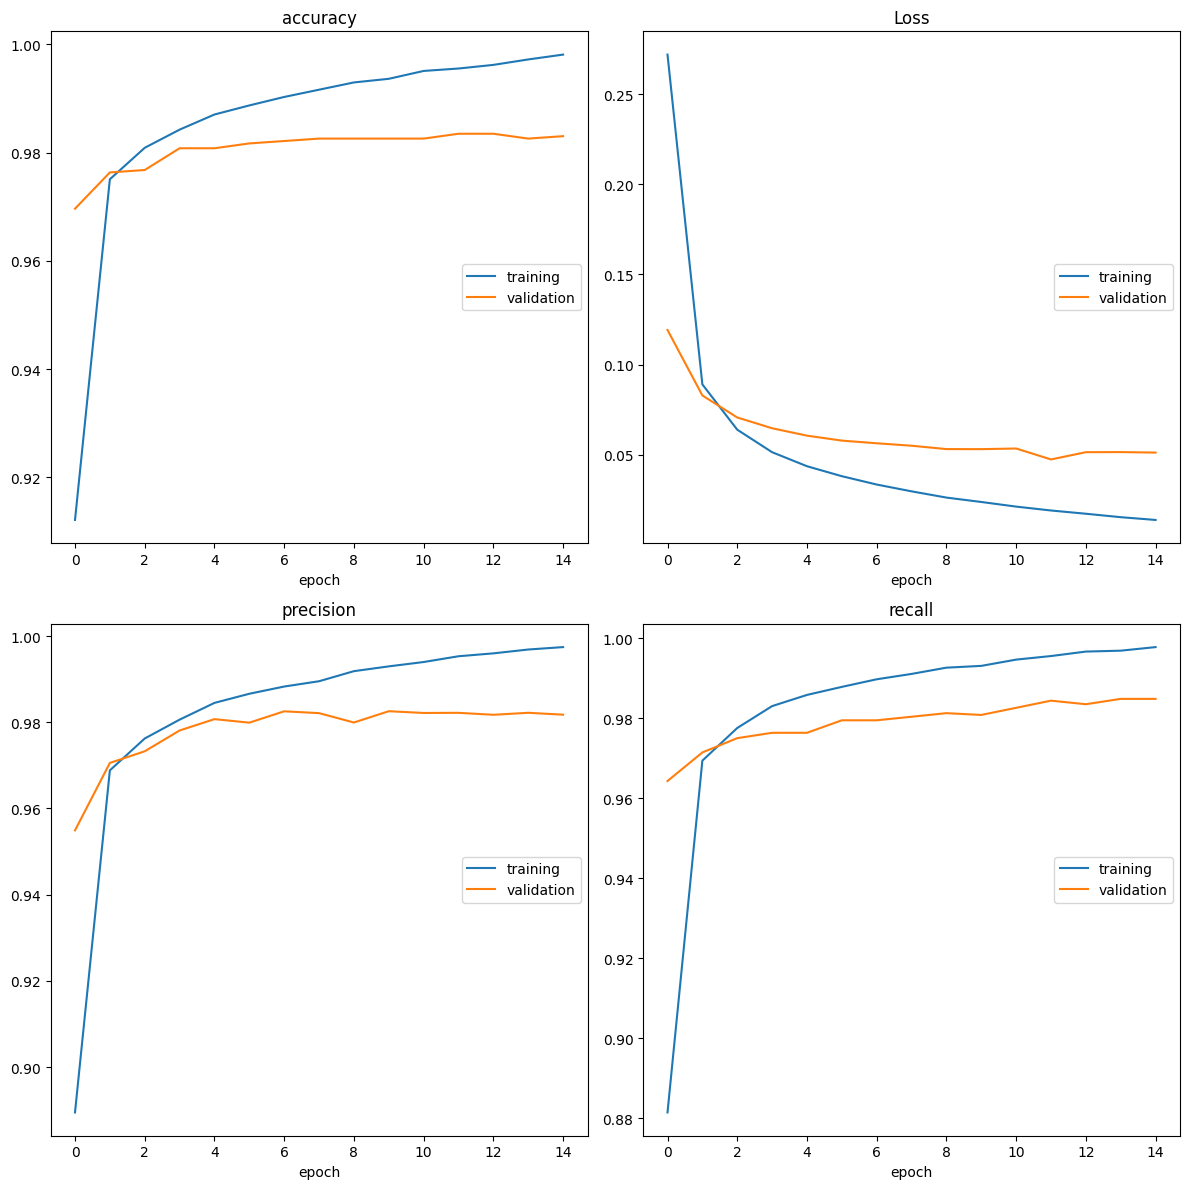

accuracy
	training         	 (min:    0.912, max:    0.998, cur:    0.998)
	validation       	 (min:    0.970, max:    0.983, cur:    0.983)
Loss
	training         	 (min:    0.014, max:    0.272, cur:    0.014)
	validation       	 (min:    0.047, max:    0.119, cur:    0.051)
precision
	training         	 (min:    0.889, max:    0.997, cur:    0.997)
	validation       	 (min:    0.955, max:    0.983, cur:    0.982)
recall
	training         	 (min:    0.881, max:    0.998, cur:    0.998)
	validation       	 (min:    0.964, max:    0.985, cur:    0.985)
280/280 [==============================] - 66s 237ms/step - loss: 0.0138 - accuracy: 0.9981 - precision: 0.9974 - recall: 0.9978 - val_loss: 0.0512 - val_accuracy: 0.9830 - val_precision: 0.9818 - val_recall: 0.9848


In [47]:
history_121 = final_model_dn_121.fit_generator(train_generator,
                                               validation_data = valid_generator,
                                               steps_per_epoch = STEP_SIZE_TRAIN,
                                               validation_steps = STEP_SIZE_VALID,
                                               epochs=epochs,
                                               callbacks=[#es_callback,
                                                         PlotLossesKeras()]
                                              )
final_model_dn_121.save('/content/drive/MyDrive/PetImages/model_dn_121.h5')

In [ ]:
final_model_dn_121 = tf.keras.models.load_model("/content/drive/MyDrive/PetImages/model_dn_121.h5")

In [48]:
print("Evaluate on test data")
eval_121 = final_model_dn_121.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
print("Validation accuracy:", eval_121[1])
print("Validation loss:", eval_121[0])
print("Validation precision:", eval_121[2])
print("Validation recall:", eval_121[3])
val_f1_121 = 2*(eval_121[2]*eval_121[3])/(eval_121[2]+eval_121[3])
print("Validation f1-score:", val_f1_121)

Evaluate on test data


<ipython-input-48-fbe4eee53e38>:2: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Validation accuracy: 0.9830357432365417
Validation loss: 0.05118658021092415
Validation precision: 0.9817534685134888
Validation recall: 0.9848214387893677
Validation f1-score: 0.9832850605461417


In [49]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

test_generator.reset()
pred_121 = final_model_dn_121.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

<ipython-input-49-66719f78ae48>:4: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



1248/1248 [==============================] - 25s 18ms/step


In [50]:
predicted_class_indices_121 = np.argmax(pred_121, axis=1)

In [51]:
filenames_121 = test_generator.filenames
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions_121 = [labels[k] for k in predicted_class_indices_121]

results_121 = pd.DataFrame({"Filename":filenames_121,
                            "Predictions":predictions_121})

results_121['Predictions'] = results_121['Predictions'].astype(int)

In [76]:
results_121[110:120]

Filename  Predictions
110   /content/drive/MyDrive/PetImages/Cat/1737.jpg            0
111    /content/drive/MyDrive/PetImages/Dog/637.jpg            1
112   /content/drive/MyDrive/PetImages/Cat/9803.jpg            0
113   /content/drive/MyDrive/PetImages/Dog/7379.jpg            1
114  /content/drive/MyDrive/PetImages/Dog/11289.jpg            1
115  /content/drive/MyDrive/PetImages/Cat/10366.jpg            0
116   /content/drive/MyDrive/PetImages/Cat/8884.jpg            0
117   /content/drive/MyDrive/PetImages/Dog/2947.jpg            1
118   /content/drive/MyDrive/PetImages/Cat/2845.jpg            1
119  /content/drive/MyDrive/PetImages/Cat/11837.jpg            0

In [77]:
results_121_ = results_121.iloc[110:135,:]
results_121_.reset_index(drop=True, inplace=True)

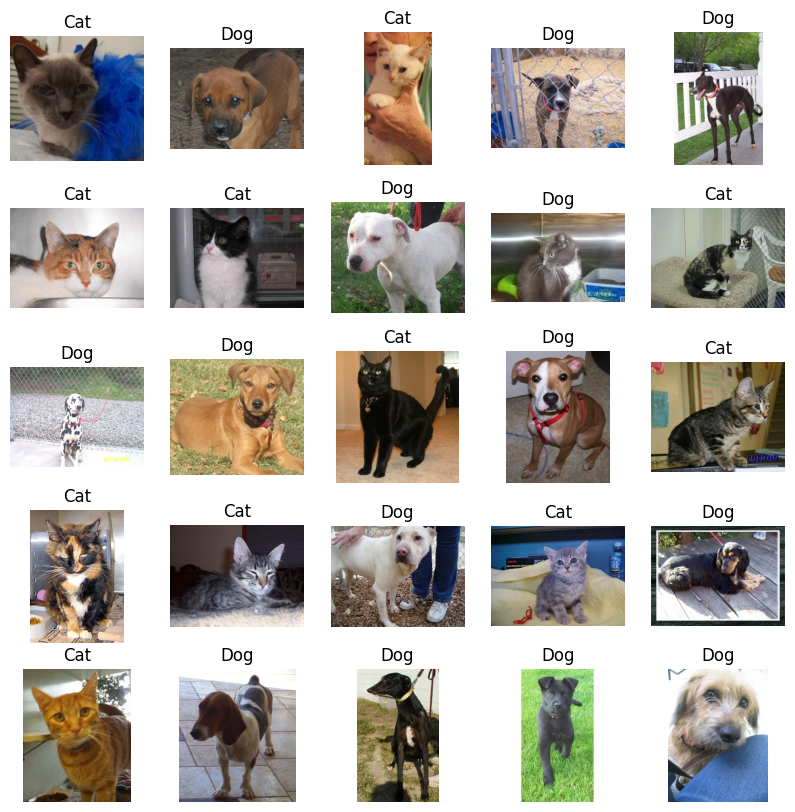

In [78]:
show_25_images(results_121_['Filename'], results_121_['Predictions'])

DenseNet169

In [79]:
model_dn_169 = DenseNet169(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

51877672/51877672 [==============================] - 1s 0us/step


In [80]:
for layer in model_dn_169.layers:
    layer.trainable = False

x = Flatten()(model_dn_169.output)
pred_169 = Dense(2, activation = 'sigmoid')(x)
final_model_dn_169 = Model(inputs = model_dn_169.input, outputs = pred_169)

final_model_dn_169.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [81]:
final_model_dn_169.compile(loss="binary_crossentropy",
                           optimizer=Adam(learning_rate=0.00001),
                           metrics=['accuracy',
                                    #tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                                    tf.keras.metrics.Precision(name='precision'),
                                    tf.keras.metrics.Recall(name='recall')
                                   ])

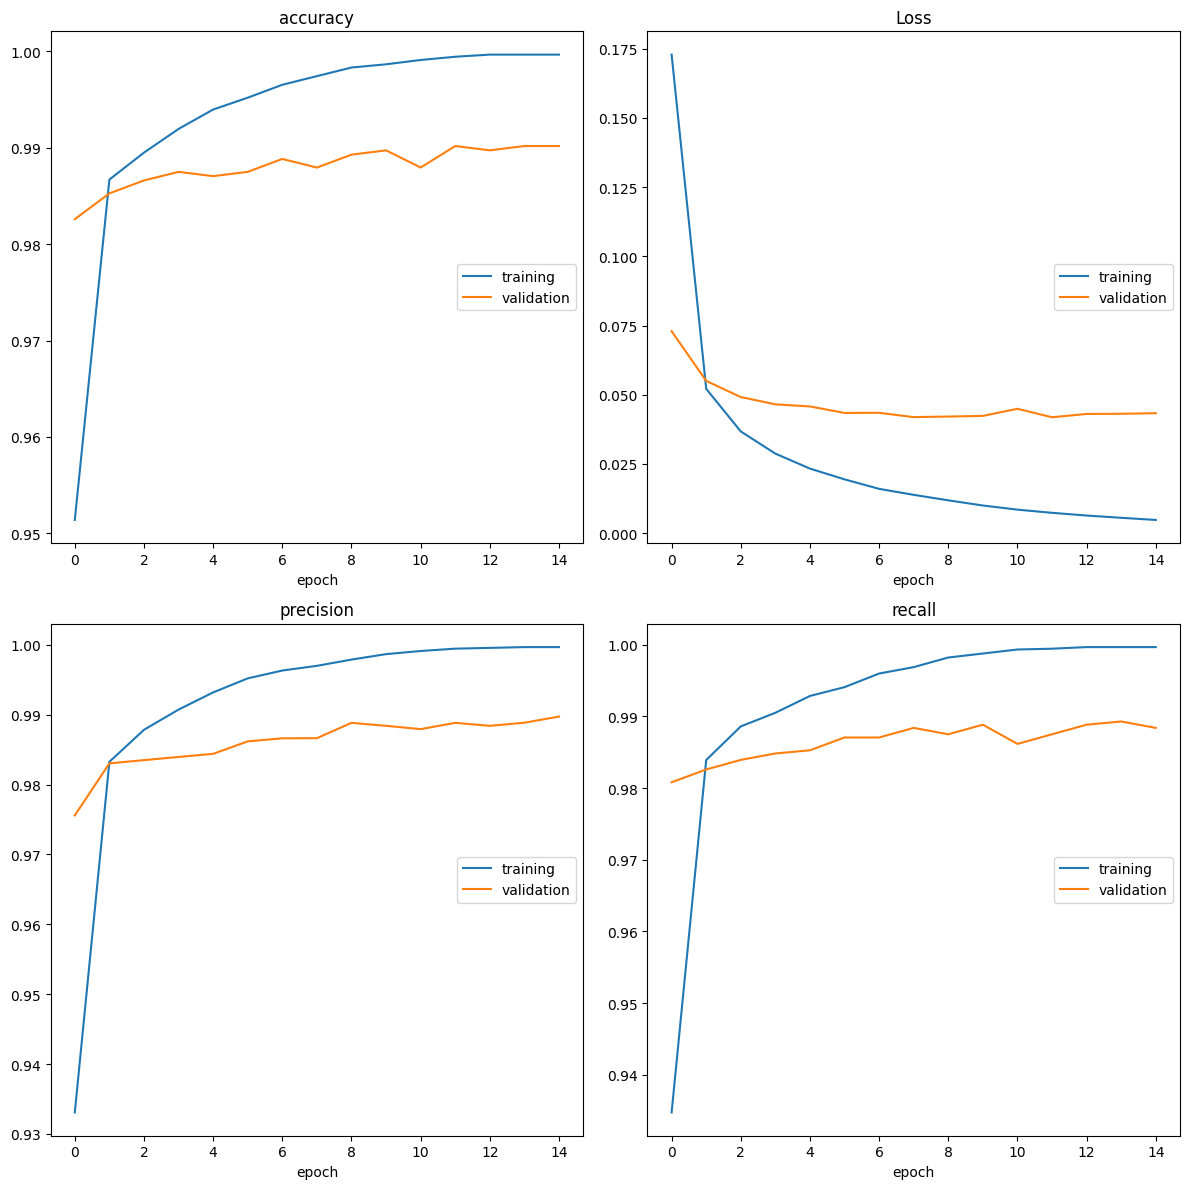

accuracy
	training         	 (min:    0.951, max:    1.000, cur:    1.000)
	validation       	 (min:    0.983, max:    0.990, cur:    0.990)
Loss
	training         	 (min:    0.005, max:    0.173, cur:    0.005)
	validation       	 (min:    0.042, max:    0.073, cur:    0.043)
precision
	training         	 (min:    0.933, max:    1.000, cur:    1.000)
	validation       	 (min:    0.976, max:    0.990, cur:    0.990)
recall
	training         	 (min:    0.935, max:    1.000, cur:    1.000)
	validation       	 (min:    0.981, max:    0.989, cur:    0.988)
280/280 [==============================] - 73s 261ms/step - loss: 0.0047 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.0433 - val_accuracy: 0.9902 - val_precision: 0.9897 - val_recall: 0.9884


In [82]:
history_169 = final_model_dn_169.fit_generator(train_generator,
                                               validation_data = valid_generator,
                                               steps_per_epoch = STEP_SIZE_TRAIN,
                                               validation_steps = STEP_SIZE_VALID,
                                               epochs=epochs,
                                               callbacks=[#es_callback,
                                                          PlotLossesKeras()]
                                              )
final_model_dn_169.save('/content/drive/MyDrive/PetImages/model_dn_169.h5')

In [ ]:
final_model_dn_169 = tf.keras.models.load_model("/content/drive/MyDrive/PetImages/model_dn_169.h5")

In [84]:
print("Evaluate on test data")
eval_169 = final_model_dn_169.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
print("Validation accuracy:", eval_169[1])
print("Validation loss:", eval_169[0])
print("Validation precision:", eval_169[2])
print("Validation recall:", eval_169[3])
val_f1_169 = 2*(eval_169[2]*eval_169[3])/(eval_169[2]+eval_169[3])
print("Validation f1-score:", val_f1_169)

Evaluate on test data


<ipython-input-84-9baf6cdf4b25>:2: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Validation accuracy: 0.9901785850524902
Validation loss: 0.04332415387034416
Validation precision: 0.9897183775901794
Validation recall: 0.9883928298950195
Validation f1-score: 0.9890551596126927


In [85]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

test_generator.reset()
pred_169 = final_model_dn_169.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

<ipython-input-85-dd2eebb9768e>:4: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



1248/1248 [==============================] - 32s 23ms/step


In [86]:
predicted_class_indices_169 = np.argmax(pred_169, axis=1)

In [87]:
filenames_169 = test_generator.filenames
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions_169 = [labels[k] for k in predicted_class_indices_169]

results_169 = pd.DataFrame({"Filename":filenames_169,
                            "Predictions":predictions_169})

results_169['Predictions'] = results_169['Predictions'].astype(int)

In [88]:
results_169[210:220]

Filename  Predictions
210  /content/drive/MyDrive/PetImages/Cat/10813.jpg            0
211   /content/drive/MyDrive/PetImages/Dog/1292.jpg            1
212   /content/drive/MyDrive/PetImages/Dog/7827.jpg            1
213   /content/drive/MyDrive/PetImages/Dog/7960.jpg            1
214  /content/drive/MyDrive/PetImages/Dog/10834.jpg            1
215  /content/drive/MyDrive/PetImages/Cat/12077.jpg            0
216   /content/drive/MyDrive/PetImages/Cat/5125.jpg            0
217   /content/drive/MyDrive/PetImages/Cat/3797.jpg            0
218   /content/drive/MyDrive/PetImages/Cat/6717.jpg            0
219   /content/drive/MyDrive/PetImages/Dog/2823.jpg            1

In [89]:
results_169_ = results_169.iloc[210:235,:]
results_169_.reset_index(drop=True, inplace=True)

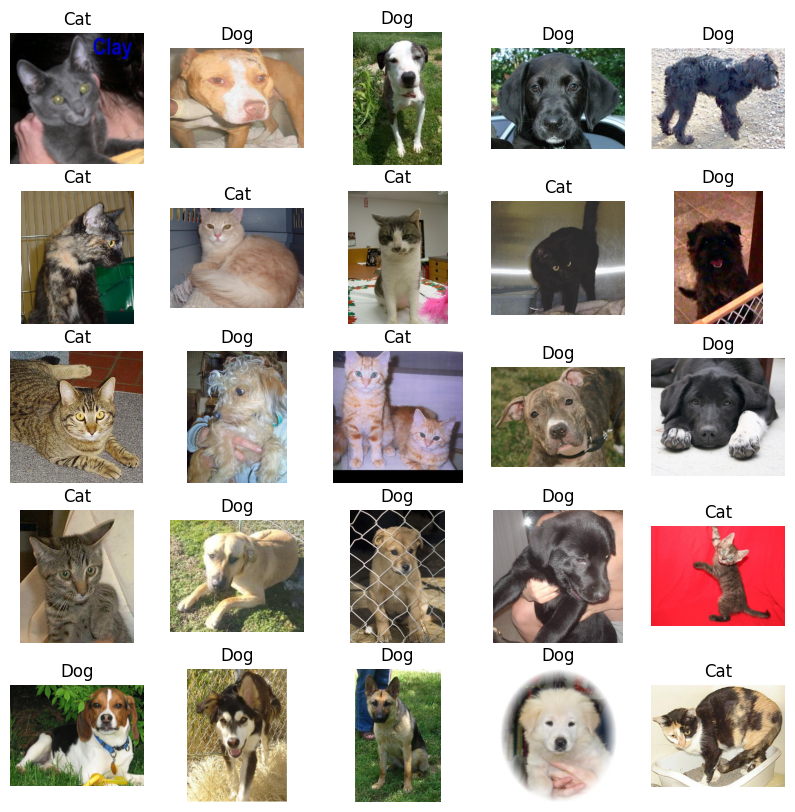

In [90]:
show_25_images(results_169_['Filename'], results_169_['Predictions'])

DenseNet201

In [91]:
model_dn_201 = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [92]:
for layer in model_dn_201.layers:
    layer.trainable = False

x = Flatten()(model_dn_201.output)
pred_201 = Dense(2, activation = 'sigmoid')(x)
final_model_dn_201 = Model(inputs = model_dn_201.input, outputs = pred_201)

final_model_dn_201.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

In [93]:
final_model_dn_201.compile(loss="binary_crossentropy",
                           optimizer=Adam(learning_rate=0.00001),
                           metrics=['accuracy',
                                    #tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                                    tf.keras.metrics.Precision(name='precision'),
                                    tf.keras.metrics.Recall(name='recall')
                                   ])

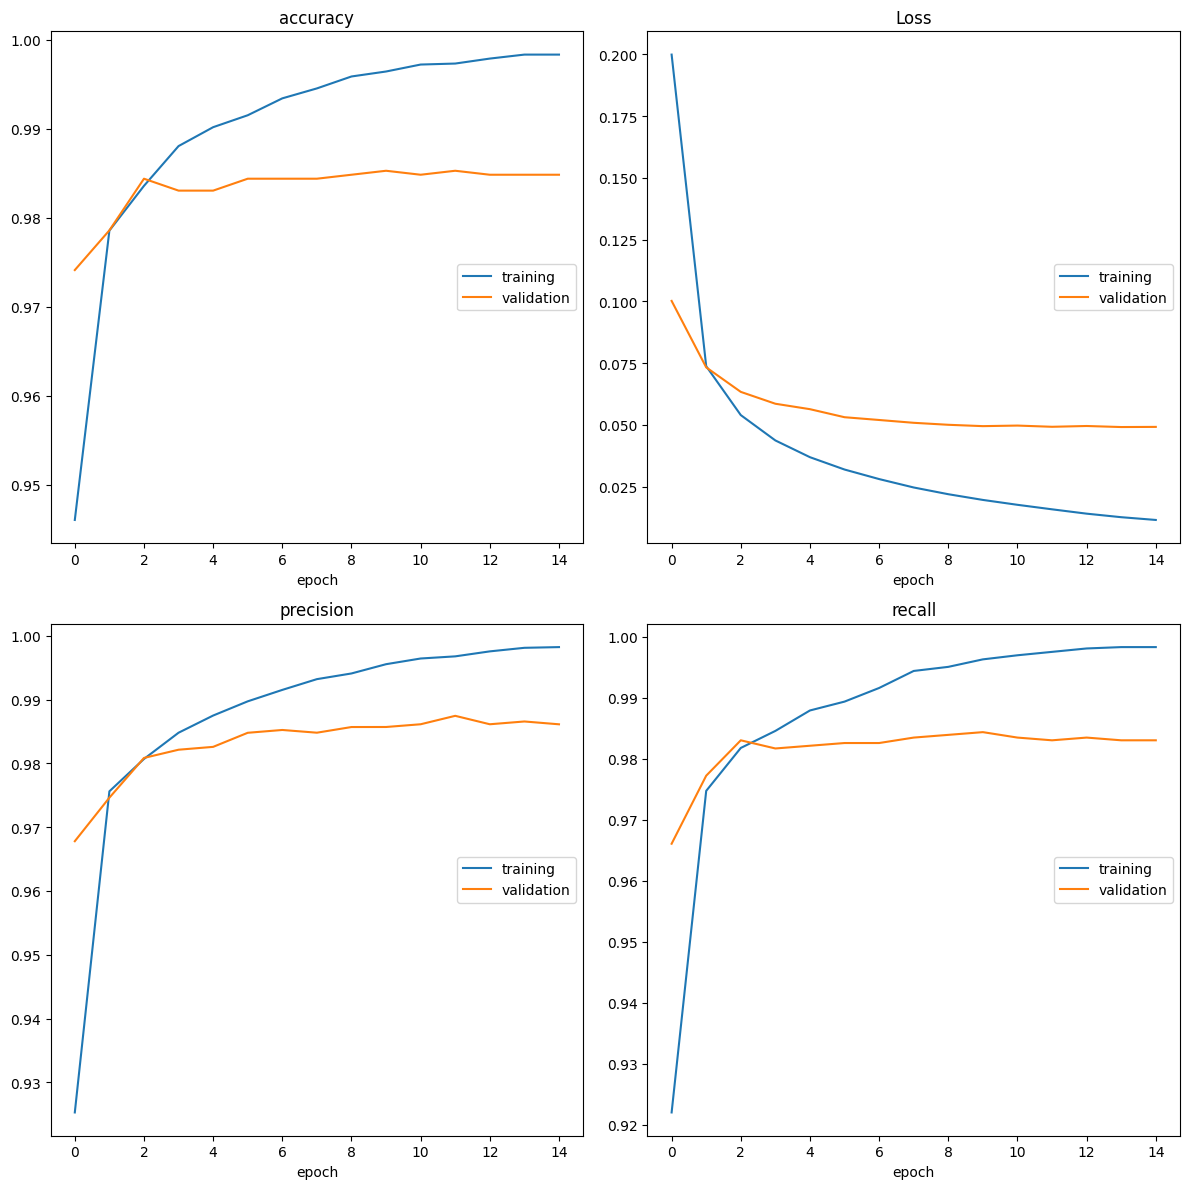

accuracy
	training         	 (min:    0.946, max:    0.998, cur:    0.998)
	validation       	 (min:    0.974, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.011, max:    0.200, cur:    0.011)
	validation       	 (min:    0.049, max:    0.100, cur:    0.049)
precision
	training         	 (min:    0.925, max:    0.998, cur:    0.998)
	validation       	 (min:    0.968, max:    0.987, cur:    0.986)
recall
	training         	 (min:    0.922, max:    0.998, cur:    0.998)
	validation       	 (min:    0.966, max:    0.984, cur:    0.983)
280/280 [==============================] - 66s 236ms/step - loss: 0.0115 - accuracy: 0.9983 - precision: 0.9982 - recall: 0.9983 - val_loss: 0.0491 - val_accuracy: 0.9848 - val_precision: 0.9861 - val_recall: 0.9830


In [94]:
history_201 = final_model_dn_201.fit_generator(train_generator,
                                          validation_data = valid_generator,
                                          steps_per_epoch = STEP_SIZE_TRAIN,
                                          validation_steps = STEP_SIZE_VALID,
                                          epochs=epochs,
                                          callbacks=[#es_callback,
                                                     PlotLossesKeras()]
                                          )
final_model_dn_201.save('/content/drive/MyDrive/PetImages/model_dn_201.h5')

In [27]:
final_model_dn_201 = tf.keras.models.load_model("/content/drive/MyDrive/PetImages/model_dn_201.h5")

In [95]:
print("Evaluate on test data")
eval_201 = final_model_dn_201.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
print("Validation accuracy:", eval_201[1])
print("Validation loss:", eval_201[0])
print("Validation precision:", eval_201[2])
print("Validation recall:", eval_201[3])
val_f1_201 = 2*(eval_201[2]*eval_201[3])/(eval_201[2]+eval_201[3])
print("Validation f1-score:", val_f1_201)

Evaluate on test data


<ipython-input-95-1473e450a7a5>:2: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Validation accuracy: 0.9848214387893677
Validation loss: 0.04913811758160591
Validation precision: 0.9861173033714294
Validation recall: 0.9830357432365417
Validation f1-score: 0.9845741121118029


In [96]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

test_generator.reset()
pred_201 = final_model_dn_201.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

<ipython-input-96-cf95e4b6f051>:4: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



1248/1248 [==============================] - 25s 18ms/step


In [97]:
predicted_class_indices_201 = np.argmax(pred_201, axis=1)


In [98]:
filenames_201 = test_generator.filenames
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions_201 = [labels[k] for k in predicted_class_indices_201]

results_201 = pd.DataFrame({"Filename":filenames_201,
                            "Predictions":predictions_201})

results_201['Predictions'] = results_201['Predictions'].astype(int)

In [99]:
results_201[310:320]

Filename  Predictions
310   /content/drive/MyDrive/PetImages/Cat/234.jpg            0
311  /content/drive/MyDrive/PetImages/Cat/4501.jpg            0
312    /content/drive/MyDrive/PetImages/Cat/54.jpg            0
313  /content/drive/MyDrive/PetImages/Cat/4372.jpg            0
314  /content/drive/MyDrive/PetImages/Cat/6669.jpg            0
315  /content/drive/MyDrive/PetImages/Cat/9136.jpg            0
316  /content/drive/MyDrive/PetImages/Cat/2955.jpg            0
317  /content/drive/MyDrive/PetImages/Cat/2596.jpg            0
318  /content/drive/MyDrive/PetImages/Dog/7470.jpg            1
319  /content/drive/MyDrive/PetImages/Cat/5747.jpg            0

In [102]:
results_201_ = results_201.iloc[310:335,:]
results_201_.reset_index(drop=True, inplace=True)

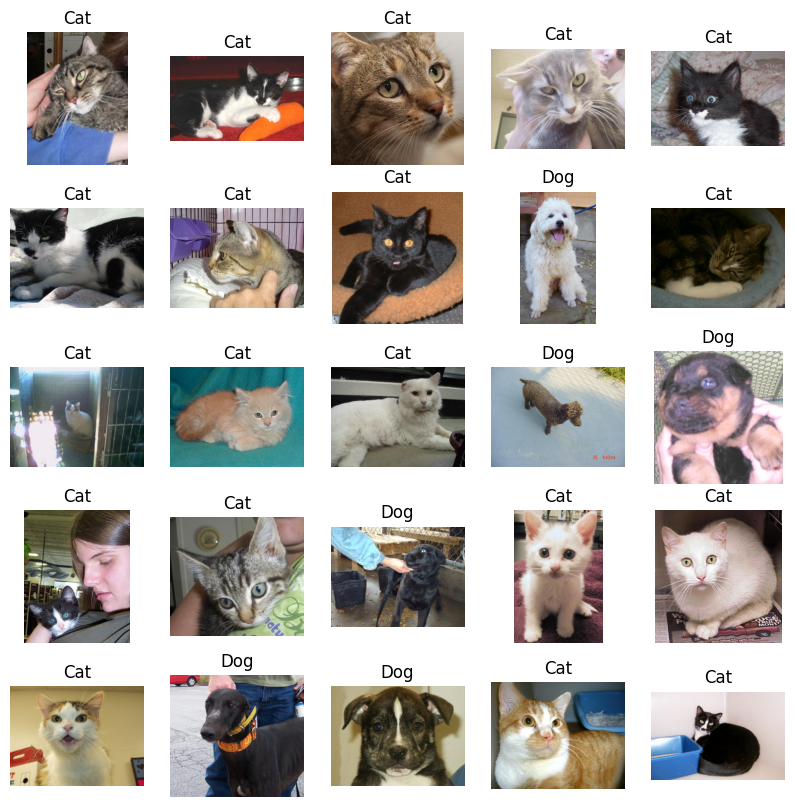

In [103]:
show_25_images(results_201_['Filename'], results_201_['Predictions'])